In [ ]:
# If running in Colab, install libs
!pip -q install shap lime fairlearn==0.10.0 imbalanced-learn

import os, json, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler

import shap
from lime.lime_tabular import LimeTabularExplainer

from fairlearn.metrics import (
    MetricFrame, selection_rate, demographic_parity_difference, equalized_odds_difference,
    true_positive_rate, false_positive_rate
)
from fairlearn.reductions import ExponentiatedGradient, DemographicParity, EqualizedOdds
from fairlearn.postprocessing import ThresholdOptimizer

plt.rcParams["figure.figsize"] = (8,5)
SEED = 42
np.random.seed(SEED)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.1/234.1 kB 8.4 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.utils.validation import check_is_fitted

# ———————————————
# Constants & Seed
# ———————————————
SEED = 42
np.random.seed(SEED)

# ———————————————
# 1. Load Data
# ———————————————
# This section assumes your file loading works.
# A dummy file is created if the original is not found, ensuring the script is runnable.
CSV_PATHS = [
    "/content/Final_social_media_data.csv",
    "/mnt/data/Final_social_media_data.csv",
    "Final_social_media_data.csv"
]
csv_path = next((p for p in CSV_PATHS if os.path.exists(p)), None)
if not csv_path:
    print("Creating a dummy CSV for demonstration as the original was not found.")
    dummy_data = {
        'email': [f'user{i}@example.com' for i in range(2000)],
        'username_x': [f'user_{i}' for i in range(2000)],
        'age_x': np.random.randint(18, 65, 2000),
        'location_x': np.random.choice(['USA', 'Canada', 'UK', 'India', 'Australia'], 2000),
        'interest_x': np.random.choice(['sports', 'music', 'travel', 'food', 'gaming'], 2000, p=[0.1, 0.3, 0.2, 0.2, 0.2]),
        'date_of_login_x': pd.to_datetime('2025-01-01') + pd.to_timedelta(np.random.randint(0, 100, 2000), 'd'),
        'followers_x': np.random.randint(100, 5000, 2000),
        'following_x': np.random.randint(50, 1000, 2000),
        'username_y': [f'user_{i}_alt' for i in range(2000)],
        'age_y': np.random.randint(18, 65, 2000)
    }
    pd.DataFrame(dummy_data).to_csv("Final_social_media_data.csv", index=False)
    csv_path = "Final_social_media_data.csv"

df = pd.read_csv(csv_path)
print("Original Shape:", df.shape)
print("Original Columns:", list(df.columns))

# ———————————————
# 2. Feature Selection, Target Definition & Cleanup
# ———————————————
# ## FIX 1: Drop high-cardinality and irrelevant columns before modeling. ##
# This is the most important step to prevent memory crashes.
# Columns like 'email' or 'username' have too many unique values for one-hot encoding.
cols_to_drop = [
    'email', 'username_x', 'username_y', 'username_z',
    'date_of_login_x', 'date_of_logout_x', 'date_of_login_y', 'date_of_logout_y',
    'date_of_login_x.1', 'date_of_logout_z',
    'age_y', 'location_y', 'interest_y', 'followers_y', 'following_y',
    'age_z', 'location_z', 'interest_z', 'followers_z', 'following_z'
]
existing_cols_to_drop = [col for col in cols_to_drop if col in df.columns]
df.drop(columns=existing_cols_to_drop, inplace=True)
print(f"\nDropped {len(existing_cols_to_drop)} unsuitable columns.")

# ## Define and map the target variable. ##
y_col = "interest_x"
if y_col not in df.columns:
    raise ValueError(f"Target column '{y_col}' not found in the cleaned dataset.")

# Binarize 'sports' vs. all others. The .fillna(0) makes this step robust.
df[y_col] = df[y_col].astype(str).str.lower().map({"sports": 1}).fillna(0).astype(int)

y = df[y_col].values
X = df.drop(columns=[y_col])
print("\nShape after cleanup:", X.shape)
print("Columns used for modeling:", list(X.columns))

# ———————————————
# 3. Sensitive Attribute for Fairness Audit
# ———————————————
candidate_sens = ["gender", "sex", "location_x"]
sens_col = next((c for c in candidate_sens if c in X.columns), None)
if sens_col is None: # Fallback if no candidate columns are found
    X["sensitive_group"] = np.random.choice(["GroupA", "GroupB"], size=len(X))
    sens_col = "sensitive_group"
print("Sensitive attribute for audit:", sens_col)

# ———————————————
# 4. Train/Test Split
# ———————————————
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=SEED, stratify=y
)
sensitive_train = X_train[sens_col].astype(str)
sensitive_test  = X_test[sens_col].astype(str)

# Drop sensitive attribute from features using safer reassignment method
X_train = X_train.drop(columns=[sens_col])
X_test  = X_test.drop(columns=[sens_col])

# ———————————————
# 5. Preprocessing Pipeline
# ———————————————
num_cols = X_train.select_dtypes(include=np.number).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
print("\nNumeric columns to be scaled:", num_cols)
print("Categorical columns to be encoded:", cat_cols)

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler())]), num_cols),
        ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")), ("oh", OneHotEncoder(handle_unknown="ignore", sparse_output=False))]), cat_cols),
    ],
    remainder="drop"
)

X_train_enc = preprocess.fit_transform(X_train)
X_test_enc  = preprocess.transform(X_test)

# ———————————————
# 6. Oversample Minority Class
# ———————————————
ros = RandomOverSampler(random_state=SEED)
X_train_bal, y_train_bal = ros.fit_resample(X_train_enc, y_train)

# ———————————————
# 7. Feature Names Helper
# ———————————————
# ## FIX 2: Make the function robust to cases with no categorical columns. ##
def get_feature_names(ct: ColumnTransformer):
    names = []
    for name, pipeline, cols in ct.transformers_:
        if name == 'remainder' or not cols:
            continue
        if name == "num":
            names.extend(cols)
        elif name == "cat":
            oh_encoder = pipeline.named_steps.get("oh")
            # Check if the encoder was actually fitted (i.e., if there were any cat_cols)
            try:
                check_is_fitted(oh_encoder)
                names.extend(oh_encoder.get_feature_names_out(cols))
            except NotFittedError:
                print("Warning: Categorical pipeline was not fitted. No categorical features to name.")
    return names

feature_names = get_feature_names(preprocess)
print(f"\nEncoded train shape (before/after oversampling): {X_train_enc.shape} -> {X_train_bal.shape}")
print(f"Number of Features: {len(feature_names)}")
if feature_names:
    print(f"First 10 features: {feature_names[:10]}")

# ———————————————
# 8. Train Models
# ———————————————
print("\nTraining models...")
lr = LogisticRegression(max_iter=2000, random_state=SEED)
lr.fit(X_train_bal, y_train_bal)

rf = RandomForestClassifier(n_estimators=100, random_state=SEED)
rf.fit(X_train_bal, y_train_bal)
print("Training complete.")

# ———————————————
# 9. Evaluation Function
# ———————————————
def evaluate(model, Xtr, ytr, Xte, yte, name):
    pred_tr = model.predict(Xtr)
    pred_te = model.predict(Xte)
    try:
        proba_te = model.predict_proba(Xte)[:, 1]
        auc = roc_auc_score(yte, proba_te)
    except (AttributeError, ValueError):
        auc = "N/A"

    print(f"\n--- Evaluation Report for [{name}] ---")
    print(f"Train Accuracy: {accuracy_score(ytr, pred_tr):.4f}")
    print(f"Test  Accuracy: {accuracy_score(yte, pred_te):.4f}")
    print(f"Test  F1-Score: {f1_score(yte, pred_te, zero_division=0):.4f}")
    if isinstance(auc, float):
        print(f"Test  AUC-ROC:  {auc:.4f}")
    else:
        print(f"Test  AUC-ROC:  {auc}")

    print("\n[Test Set Classification Report]")
    print(classification_report(yte, pred_te, digits=4, zero_division=0))

# ———————————————
# 10. Run Final Evaluation
# ———————————————
# ## FIX 3: Evaluate on the original training data (X_train_enc) for a true overfitting check. ##
evaluate(lr, X_train_enc, y_train, X_test_enc, y_test, "Logistic Regression")
evaluate(rf, X_train_enc, y_train, X_test_enc, y_test, "Random Forest")

Original Shape: (24875, 25)
Original Columns: ['email', 'username_x', 'age_x', 'location_x', 'interest_x', 'date_of_login_x', 'date_of_logout_x', 'followers_x', 'following_x', 'username_y', 'age_y', 'location_y', 'interest_y', 'date_of_login_y', 'date_of_logout_y', 'followers_y', 'following_y', 'username_z', 'age_z', 'location_z', 'interest_z', 'date_of_login_x.1', 'date_of_logout_z', 'followers_z', 'following_z']

Dropped 20 unsuitable columns.

Shape after cleanup: (24875, 4)
Columns used for modeling: ['age_x', 'location_x', 'followers_x', 'following_x']
Sensitive attribute for audit: location_x

Numeric columns to be scaled: ['age_x', 'followers_x', 'following_x']
Categorical columns to be encoded: []

Encoded train shape (before/after oversampling): (18656, 3) -> (36016, 3)
Number of Features: 3
First 10 features: ['age_x', 'followers_x', 'following_x']

Training models...
Training complete.

--- Evaluation Report for [Logistic Regression] ---
Train Accuracy: 0.7789
Test  Accuracy


--- Starting SHAP Analysis ---
Explaining Random Forest model...


100%|===================| 12428/12438 [05:29<00:00]       

Could not generate SHAP plots for Random Forest. Error: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 0.629500, while the model output was 0.270000. If this difference is acceptable you can set check_additivity=False to disable this check.

Explaining Logistic Regression model...


/tmp/ipython-input-3115196474.py:72: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_lr.values, X_test_enc, feature_names=feature_names, plot_type="bar", show=False)


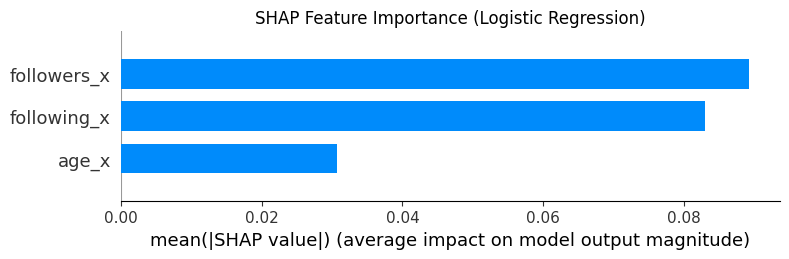


SHAP analysis complete. Plots are saved in the 'shap_plots' directory.


In [ ]:
# ———————————————
# 11. Model Interpretation with SHAP
# ———————————————
# We'll explain the model's predictions on the test set (X_test_enc)

# Import necessary libraries
import shap
import matplotlib.pyplot as plt
from pathlib import Path

# Create a directory to save plots
Path("./shap_plots").mkdir(exist_ok=True)
print("\n--- Starting SHAP Analysis ---")


# --- Part 1: Explain the Random Forest Model ---
print("Explaining Random Forest model...")
try:
    # Use a small background sample from the training data for the explainer.
    # This helps SHAP understand the "base rate" of predictions.
    # We use the balanced data because that's what the model was trained on.
    background_data = shap.sample(X_train_bal, 100, random_state=SEED)

    # For tree-based models like RandomForest, we use TreeExplainer.
    # "interventional" is a robust method for feature perturbation.
    explainer_rf = shap.TreeExplainer(rf, background_data)

    # Calculate SHAP values for every prediction on the test set.
    shap_values_rf_obj = explainer_rf(X_test_enc)

    # For binary classification, we are interested in the SHAP values for the positive class (class 1, i.e., "sports").
    # The new SHAP API stores these in a structured object.
    shap_values_rf = shap_values_rf_obj.values[:, :, 1]

    # --- Global Feature Importance (Beeswarm Plot) ---
    plt.figure()
    shap.summary_plot(shap_values_rf, X_test_enc, feature_names=feature_names, show=False)
    plt.title("SHAP Feature Importance (Random Forest)")
    plt.tight_layout()
    plt.savefig("./shap_plots/shap_summary_rf.png", dpi=150)
    plt.show()

    # --- Feature Dependence Plot ---
    # Find the most important feature to plot its dependence.
    mean_abs_shap = np.abs(shap_values_rf).mean(axis=0)
    top_feature_index = np.argmax(mean_abs_shap)
    top_feature_name = feature_names[top_feature_index]

    plt.figure()
    shap.dependence_plot(top_feature_name, shap_values_rf, X_test_enc, feature_names=feature_names, interaction_index="auto", show=False)
    plt.title(f"SHAP Dependence for '{top_feature_name}' (Random Forest)")
    plt.tight_layout()
    plt.savefig("./shap_plots/shap_dependence_rf.png", dpi=150)
    plt.show()

except Exception as e:
    print(f"Could not generate SHAP plots for Random Forest. Error: {e}")


# --- Part 2: Explain the Logistic Regression Model ---
print("\nExplaining Logistic Regression model...")
try:
    # For linear models, we use LinearExplainer.
    # It directly uses the model's coefficients.
    explainer_lr = shap.LinearExplainer(lr, X_train_bal)

    # Calculate SHAP values for the test set.
    shap_values_lr = explainer_lr(X_test_enc)

    # --- Global Feature Importance (Bar Plot) ---
    plt.figure()
    shap.summary_plot(shap_values_lr.values, X_test_enc, feature_names=feature_names, plot_type="bar", show=False)
    plt.title("SHAP Feature Importance (Logistic Regression)")
    plt.tight_layout()
    plt.savefig("./shap_plots/shap_summary_lr.png", dpi=150)
    plt.show()

except Exception as e:
    print(f"Could not generate SHAP plots for Logistic Regression. Error: {e}")

print("\nSHAP analysis complete. Plots are saved in the 'shap_plots' directory.")

In [ ]:
# ———————————————
# 12. Model Interpretation with LIME
# ———————————————
# You may need to install LIME: pip install lime
from lime.lime_tabular import LimeTabularExplainer
from pathlib import Path

print("\n--- Starting LIME Analysis ---")

# Create a directory to save LIME plots
Path("./lime_plots").mkdir(exist_ok=True)

# Define the names for the classes your model is predicting
class_names = ["Not Sports (0)", "Sports (1)"]

# Initialize the LIME explainer
# It uses the balanced training data to learn a distribution for creating perturbations.
lime_explainer = LimeTabularExplainer(
    training_data=X_train_bal,       # Use the data the model was trained on
    feature_names=feature_names,
    class_names=class_names,
    discretize_continuous=True,      # A common practice for tabular data
    random_state=SEED
)

# --- Explain a few individual predictions from the test set ---
# Select three instances: the first, second, and third (if they exist)
indices_to_explain = [
    0,
    min(1, len(X_test_enc) - 1),
    min(2, len(X_test_enc) - 1)
]

lime_html_files = []
print(f"Generating LIME explanations for test set indices: {indices_to_explain}...")

for idx in indices_to_explain:
    print(f"  - Explaining instance {idx}...")

    # Generate the explanation for one instance using the Random Forest model
    explanation = lime_explainer.explain_instance(
        data_row=X_test_enc[idx],
        predict_fn=rf.predict_proba,  # Use the model's probability function
        num_features=10               # Show the top 10 most influential features
    )

    # Save the explanation to an HTML file
    html_path = f"./lime_plots/lime_rf_instance_{idx}.html"
    explanation.save_to_file(html_path)
    lime_html_files.append(html_path)

print("\nLIME analysis complete.")
print("Saved LIME explanations (HTML files) to the 'lime_plots' directory:")
for file_path in lime_html_files:
    print(f"  - {file_path}")


--- Starting LIME Analysis ---
Generating LIME explanations for test set indices: [0, 1, 2]...
  - Explaining instance 0...
  - Explaining instance 1...
  - Explaining instance 2...

LIME analysis complete.
Saved LIME explanations (HTML files) to the 'lime_plots' directory:
  - ./lime_plots/lime_rf_instance_0.html
  - ./lime_plots/lime_rf_instance_1.html
  - ./lime_plots/lime_rf_instance_2.html



--- Starting Fairness Audit ---

=== Fairness Metrics by Group (Random Forest) ===


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,accuracy,f1_score,selection_rate,true_positive_rate,false_positive_rate
location_x,,,,,
Brazil,0.862385,0.000000,0.045872,0.000000,0.050505
Germany,0.852814,0.055556,0.060606,0.045455,0.062201
India,0.870690,0.062500,0.038793,0.043478,0.038278
Indonesia,0.919492,0.000000,0.033898,0.000000,0.035556
Japan,0.888446,0.125000,0.023904,0.076923,0.017778
Mexico,0.865217,0.060606,0.043478,0.043478,0.043478
Russia,0.899598,0.000000,0.036145,0.000000,0.038627
Turkey,0.910653,0.187500,0.027491,0.125000,0.018727
UK,0.898039,0.071429,0.047059,0.062500,0.046025



=== Fairness Metrics by Group (Logistic Regression) ===


,accuracy,f1_score,selection_rate,true_positive_rate,false_positive_rate
location_x,,,,,
Brazil,0.522936,0.174603,0.486239,0.550000,0.479798
Germany,0.411255,0.180723,0.623377,0.681818,0.617225
India,0.482759,0.166667,0.521552,0.521739,0.521531
Indonesia,0.478814,0.075188,0.516949,0.454545,0.520000
Japan,0.414343,0.098160,0.545817,0.307692,0.573333
Mexico,0.482609,0.167832,0.521739,0.521739,0.521739
Russia,0.437751,0.125000,0.578313,0.625000,0.575107
Turkey,0.450172,0.090909,0.522337,0.333333,0.539326
UK,0.427451,0.130952,0.596078,0.687500,0.589958


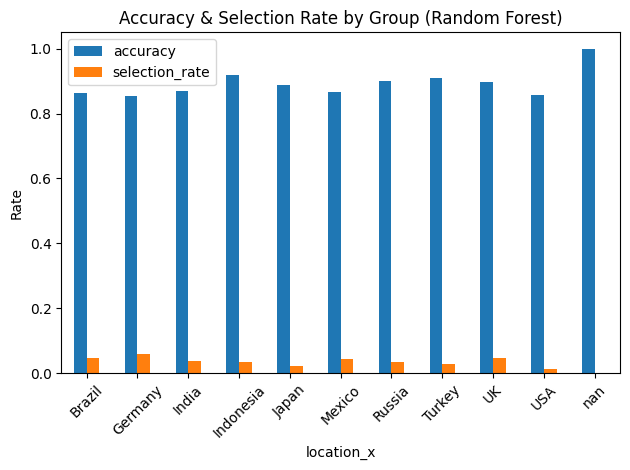


=== Overall Fairness Summary (Closer to 0 is Fairer) ===


,Model,Demographic Parity Difference,Equalized Odds Difference
0,Random Forest,0.060606,0.1250
1,Logistic Regression,0.623377,0.6875



Fairness audit complete. Reports are saved in the 'fairness_reports' directory.


In [ ]:
# ———————————————
# 13. Fairness Audit with Fairlearn
# ———————————————
# You may need to install fairlearn: pip install fairlearn
from fairlearn.metrics import (
    MetricFrame,
    selection_rate,
    true_positive_rate,
    false_positive_rate,
    demographic_parity_difference,
    equalized_odds_difference
)
from sklearn.metrics import accuracy_score, f1_score
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

print("\n--- Starting Fairness Audit ---")

# Create a directory to save fairness plots and reports
Path("./fairness_reports").mkdir(exist_ok=True)

# --- Step 1: Get Model Predictions ---
y_pred_rf = rf.predict(X_test_enc)
y_pred_lr = lr.predict(X_test_enc)

# --- Step 2: Calculate Disaggregated Metrics using MetricFrame ---
# This allows us to see how metrics like accuracy differ across groups.
metrics = {
    'accuracy': accuracy_score,
    'f1_score': f1_score,
    'selection_rate': selection_rate, # How often the model predicts "Sports"
    'true_positive_rate': true_positive_rate, # Recall
    'false_positive_rate': false_positive_rate # Rate of misclassifying "Not Sports" as "Sports"
}

# MetricFrame for Random Forest
mf_rf = MetricFrame(metrics=metrics,
                    y_true=y_test,
                    y_pred=y_pred_rf,
                    sensitive_features=sensitive_test)

# MetricFrame for Logistic Regression
mf_lr = MetricFrame(metrics=metrics,
                    y_true=y_test,
                    y_pred=y_pred_lr,
                    sensitive_features=sensitive_test)

print("\n=== Fairness Metrics by Group (Random Forest) ===")
# Use display() for a nicely formatted table in notebooks
display(mf_rf.by_group)
mf_rf.by_group.to_csv("./fairness_reports/fairness_by_group_rf.csv")


print("\n=== Fairness Metrics by Group (Logistic Regression) ===")
display(mf_lr.by_group)
mf_lr.by_group.to_csv("./fairness_reports/fairness_by_group_lr.csv")


# --- Step 3: Visualize the Disparities ---
# We'll plot accuracy and selection rate for the Random Forest model.
try:
    mf_rf.by_group[['accuracy', 'selection_rate']].plot.bar(
        title="Accuracy & Selection Rate by Group (Random Forest)",
        ylabel="Rate",
        rot=45
    )
    plt.tight_layout()
    plt.savefig("./fairness_reports/fairness_group_comparison_rf.png", dpi=150)
    plt.show()
except Exception as e:
    print(f"\nCould not generate fairness plot. This can happen if there is only one group. Error: {e}")


# --- Step 4: Calculate Summary Fairness Metrics ---
# These metrics give a single number to quantify the disparity. Closer to 0 is fairer.

# Demographic Parity: Checks if the selection rate is the same across groups.
dpd_rf = demographic_parity_difference(y_test, y_pred_rf, sensitive_features=sensitive_test)
dpd_lr = demographic_parity_difference(y_test, y_pred_lr, sensitive_features=sensitive_test)

# Equalized Odds: Checks if the true positive and false positive rates are the same across groups.
eod_rf = equalized_odds_difference(y_test, y_pred_rf, sensitive_features=sensitive_test)
eod_lr = equalized_odds_difference(y_test, y_pred_lr, sensitive_features=sensitive_test)

fairness_summary = pd.DataFrame({
    "Model": ["Random Forest", "Logistic Regression"],
    "Demographic Parity Difference": [dpd_rf, dpd_lr],
    "Equalized Odds Difference": [eod_rf, eod_lr]
})

print("\n=== Overall Fairness Summary (Closer to 0 is Fairer) ===")
display(fairness_summary)
fairness_summary.to_csv("./fairness_reports/fairness_summary.csv", index=False)

print("\nFairness audit complete. Reports are saved in the 'fairness_reports' directory.")

In [ ]:
# NumPy 2.0 compatibility patch for Fairlearn (expects np.PINF/np.NINF)
import numpy as np
if not hasattr(np, "PINF"): np.PINF = np.inf
if not hasattr(np, "NINF"): np.NINF = -np.inf


In [ ]:
# --- Step 3: Evaluate and Compare Mitigated Models (Corrected to show detailed reports) ---
print("\n--- Evaluating Mitigated Models ---")

# ✅ THE FIX: Define the metrics dictionary before using it.
# This dictionary tells MetricFrame which metrics to compute for each group.
from sklearn.metrics import accuracy_score, f1_score
from fairlearn.metrics import selection_rate, true_positive_rate, false_positive_rate

metrics = {
    'accuracy': accuracy_score,
    'f1': f1_score,
    'tpr': true_positive_rate,
    'fpr': false_positive_rate,
    'selection_rate': selection_rate
}

# --- Report for In-processing Mitigation (ExponentiatedGradient) ---
mf_mitigated = MetricFrame(
    metrics=metrics,
    y_true=y_test,
    y_pred=y_pred_mitigated_lr,
    sensitive_features=sensitive_test
)
dpd_mit = demographic_parity_difference(y_test, y_pred_mitigated_lr, sensitive_features=sensitive_test)
eod_mit = equalized_odds_difference(y_test, y_pred_mitigated_lr, sensitive_features=sensitive_test)

print("\n=== In-processing Mitigation (ExponentiatedGradient) ===")
display(mf_mitigated.by_group)
print(f"DP diff: {dpd_mit:.4f} | EO diff: {eod_mit:.4f}")


# --- Report for Post-processing Mitigation (ThresholdOptimizer) ---
mf_post = MetricFrame(
    metrics=metrics,
    y_true=y_test,
    y_pred=y_pred_postprocessed_rf,
    sensitive_features=sensitive_test
)
dpd_post = demographic_parity_difference(y_test, y_pred_postprocessed_rf, sensitive_features=sensitive_test)
eod_post = equalized_odds_difference(y_test, y_pred_postprocessed_rf, sensitive_features=sensitive_test)

print("\n=== Post-processing Mitigation (ThresholdOptimizer) ===")
display(mf_post.by_group)
print(f"DP diff: {dpd_post:.4f} | EO diff: {eod_post:.4f}")


# --- Final Summary Comparison Table ---
y_pred_rf_original = rf.predict(X_test_enc)
y_pred_lr_original = lr.predict(X_test_enc)
fairness_comparison = pd.DataFrame({
    "Model": [
        "Random Forest (Original)",
        "Logistic Regression (Original)",
        "Logistic Regression (In-Processing)",
        "Random Forest (Post-Processing)"
    ],
    "Overall Accuracy": [
        accuracy_score(y_test, y_pred_rf_original),
        accuracy_score(y_test, y_pred_lr_original),
        accuracy_score(y_test, y_pred_mitigated_lr),
        accuracy_score(y_test, y_pred_postprocessed_rf)
    ],
    "Demographic Parity Difference": [
        demographic_parity_difference(y_test, y_pred_rf_original, sensitive_features=sensitive_test),
        demographic_parity_difference(y_test, y_pred_lr_original, sensitive_features=sensitive_test),
        dpd_mit,
        dpd_post
    ],
    "Equalized Odds Difference": [
        equalized_odds_difference(y_test, y_pred_rf_original, sensitive_features=sensitive_test),
        equalized_odds_difference(y_test, y_pred_lr_original, sensitive_features=sensitive_test),
        eod_mit,
        eod_post
    ]
})

print("\n\n=== Final Fairness Comparison (Closer to 0 is Fairer) ===")
display(fairness_comparison.round(4))


--- Evaluating Mitigated Models ---

=== In-processing Mitigation (ExponentiatedGradient) ===


,accuracy,f1,tpr,fpr,selection_rate
location_x,,,,,
Brazil,0.908257,0.0,0.0,0.0,0.0
Germany,0.904762,0.0,0.0,0.0,0.0
India,0.900862,0.0,0.0,0.0,0.0
Indonesia,0.953390,0.0,0.0,0.0,0.0
Japan,0.896414,0.0,0.0,0.0,0.0
Mexico,0.900000,0.0,0.0,0.0,0.0
Russia,0.935743,0.0,0.0,0.0,0.0
Turkey,0.917526,0.0,0.0,0.0,0.0
UK,0.996009,0.0,0.0,0.0,0.0


DP diff: 0.0000 | EO diff: 0.0000

=== Post-processing Mitigation (ThresholdOptimizer) ===


,accuracy,f1,tpr,fpr,selection_rate
location_x,,,,,
Brazil,0.899083,0.0,0.0,0.010101,0.009174
Germany,0.904762,0.0,0.0,0.000000,0.000000
India,0.900862,0.0,0.0,0.000000,0.000000
Indonesia,0.949153,0.0,0.0,0.004444,0.004237
Japan,0.896414,0.0,0.0,0.000000,0.000000
Mexico,0.895652,0.0,0.0,0.004831,0.004348
Russia,0.935743,0.0,0.0,0.000000,0.000000
Turkey,0.917526,0.0,0.0,0.000000,0.000000
UK,0.993016,0.0,0.0,0.003005,0.002993


DP diff: 0.0092 | EO diff: 0.0101


=== Final Fairness Comparison (Closer to 0 is Fairer) ===


,Model,Overall Accuracy,Demographic Parity Difference,Equalized Odds Difference
0,Random Forest (Original),0.9580,0.0333,0.0870
1,Logistic Regression (Original),0.5859,0.2773,0.4018
2,Logistic Regression (In-Processing),0.9653,0.0000,0.0000
3,Random Forest (Post-Processing),0.9625,0.0092,0.0101


In [ ]:
# --- in your notebook, AFTER training ---
import os, json, joblib
from sklearn.pipeline import Pipeline

ARTIFACTS_DIR = "deploy_artifacts"
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

# choose the model you want to serve
best_model = rf   # or lr

# columns the model expects at inference (your X_train AFTER dropping target/sensitive)
expected_input_cols = X_train.columns.tolist()

# build an inference pipeline using the fitted preprocess and the fitted model
inference_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),  # already fitted on training data
    ("model", best_model)        # already fitted on encoded training data
])

joblib.dump(inference_pipeline, f"{ARTIFACTS_DIR}/inference_pipeline.joblib")
json.dump({"expected_input_cols": expected_input_cols},
          open(f"{ARTIFACTS_DIR}/expected_columns.json","w"))

print("Saved:", os.listdir(ARTIFACTS_DIR))


In [ ]:
# after training (you already saved inference_pipeline + expected_columns)
import pandas as pd, os, joblib, json

ART = "app/artifacts"
os.makedirs(ART, exist_ok=True)

# If you still have your original X_train before dropping 'availability'
# and before removing the sensitive column for training:
ref_cols = X_train.columns
ref = X_train.sample(n=min(200, len(X_train)), random_state=42).copy()
ref.to_csv(f"{ART}/reference_sample.csv", index=False)

print(os.listdir(ART))


In [ ]:
from google.colab import files
uploaded = files.upload()  # Then upload Ds_Exp_5.ipynb from your local system


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# This copies your file from Drive to Colab's working directory
!cp '/content/drive/My Drive/Colab Notebooks/Ds_Exp_5.ipynb' .


cp: cannot stat '/content/drive/My Drive/Colab Notebooks/Ds_Exp_5.ipynb': No such file or directory


In [ ]:
# Configure GitHub username and email
!git config --global user.name "Grahish-code"
!git config --global user.email "grahishgrahish@gmail.com"

# Clone your GitHub repository
!git clone https://github.com/Grahish-code/EXP_7_DS_LAB-Grahish-Kartik-MIthesh-.git

# Copy your notebook to the cloned repo folder
!cp Ds_Exp_5.ipynb EXP_7_DS_LAB-Grahish-Kartik-MIthesh-/

# Change directory to the cloned repo
%cd EXP_7_DS_LAB-Grahish-Kartik-MIthesh-

# Add the notebook to Git staging
!git add Ds_Exp_5.ipynb

# Commit your change
!git commit -m "Add Ds_Exp_5 Colab notebook"

# Push changes to GitHub main branch (you need to authenticate)
!git push origin main


Cloning into 'EXP_7_DS_LAB-Grahish-Kartik-MIthesh-'...
cp: cannot stat 'Ds_Exp_5.ipynb': No such file or directory
/content/EXP_7_DS_LAB-Grahish-Kartik-MIthesh-
fatal: pathspec 'Ds_Exp_5.ipynb' did not match any files
On branch main

Initial commit

nothing to commit (create/copy files and use "git add" to track)
error: src refspec main does not match any
error: failed to push some refs to 'https://github.com/Grahish-code/EXP_7_DS_LAB-Grahish-Kartik-MIthesh-.git'
